# Mock generation summer 2022

In [1]:
import scipy
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo
import pandas as pd
from astropy.table import Table
from numpy.typing import ArrayLike
%matplotlib inline

Assumptions:

* All AGN ( this assuption reasonable as we have selected to have a purity of 90% AGN in the cluster. The purity of the background changes in different redhisft bin but we can use the SDWFS to give the the empirical way this is expected to change for background AGN)
* 

Steps will be:

* Field 
 * Homogenous process
 * Typically cut outs are sized 5 x 5 arcmins
 * Rough background density per arcmin squared is 0.6
 * Drawn from SDWFS - can draw for any colour cut
  * E.g. cluster at 0.4 has a colour threshold of 0.6 - so we do a straight cut at 0.6 meaning at the cluster redshift the AGN have a 90% purity and the background is predictale.
* Cluster
 * Non-homogenous process

TO DO - look for 'CHANGE ME' in code below

* bk sources
 * add columns for the ch1 and ch2 uncertinaites
 * selection membership for bk sources - change the uniform selection below to a weight selection based on the colour cut
* cluster sources
 * also weighting 
* Model - didn't get too far with this - think need to change shapes of things

# FUNCTIONS

### SDWFS Data

In [2]:
def read_sdwfs(file1: str='ch2v33_sdwfs_2009mar3_apcorr_matched_ap4_Main_v0.4.cat', file2: str='mbz_v0.06_prior_bri12_18p8.cat') -> Table:
    from astropy.table import Table, join
    '''
    This code reads in the SDWFS data needed to draw from the create the appropriate background
    magnitudes (and redshifts but only for testing).
    '''
    # Read in the SDWFS photometric catalog
    sdwfs_main = Table.read(file1,
                            names=['ID', 'IRAC_RA', 'IRAC_DEC', 'B_APFLUX4', 'R_APFLUX4', 'I_APFLUX4', 'B_APFLUXERR4',
                                   'R_APFLUXERR4', 'I_APFLUXERR4', 'B_APMAG4', 'R_APMAG4', 'I_APMAG4', 'B_APMAGERR4',
                                   'R_APMAGERR4', 'I_APMAGERR4', 'CH1_APFLUX4', 'CH2_APFLUX4', 'CH3_APFLUX4', 'CH4_APFLUX4',
                                   'CH1_APFLUXERR4', 'CH2_APFLUXERR4', 'CH3_APFLUXERR4', 'CH4_APFLUXERR4',
                                   'CH1_APFLUXERR4_BROWN', 'CH2_APFLUXERR4_BROWN', 'CH3_APFLUXERR4_BROWN',
                                   'CH4_APFLUXERR4_BROWN', 'CH1_APMAG4', 'CH2_APMAG4', 'CH3_APMAG4', 'CH4_APMAG4',
                                   'CH1_APMAGERR4', 'CH2_APMAGERR4', 'CH3_APMAGERR4', 'CH4_APMAGERR4',
                                   'CH1_APMAGERR4_BROWN', 'CH2_APMAGERR4_BROWN', 'CH3_APMAGERR4_BROWN',
                                   'CH4_APMAGERR4_BROWN', 'STARS_COLOR', 'STARS_MORPH', 'CLASS_STAR', 'MBZ_FLAG_4_4_4'],
                            format='ascii')

    # Read in the photometric redshift catalog
    sdwfs_photz = Table.read(file2,
                             names=['ID', 'PHOT_Z', 'col3', 'col4', 'col5', 'col6', 'col7'],
                             format='ascii',
                             include_names=['ID', 'PHOT_Z'])

    # Join the two catalogs together
    sdwfs_cat = join(sdwfs_main, sdwfs_photz, keys='ID')
    
    return sdwfs_cat

### Homogeneous poisson process

In [3]:
def h_PoissonPP(rt: float, Dx: int, Dy: int=None) -> np.ndarray:
    """
    Homogeneous Poisson Process

    Determines the number of events `N` for a rectangular region,
    given the rate `rt` and the dimensions, `Dx`, `Dy`.
    Returns a <2xN> NumPy array.

    The rate is a number of sources per area.
    """
    if Dy is None:
        Dy = Dx
    N = stats.poisson( rt*Dx*Dy ).rvs()
    x = stats.uniform.rvs(0, Dx, (N, 1))
    y = stats.uniform.rvs(0, Dy, (N, 1))
    P = np.hstack((x,y))
    return P

# Cosmology and set up

In [4]:
redshift = 0.6
redshift_uncert = 0.03 # this just to draw from sdwfs
print('one cluster at redshift: ', redshift)
kpc_per_arcmin = cosmo.kpc_proper_per_arcmin(redshift)
print('kpc per arcmin: ', kpc_per_arcmin)

ra = 33.106 # in degrees
dec = -46.950 # in degrees

color_cut_at_z = 0.61
mag_cut_ch1_f = 10. # 3.6 > 10.
mag_cut_ch2_f = 10.45 # 4.5 > 10.45
mag_cut_ch2_b = 17.46 # 4.5 < 17.46

Dx = Dy = 5. # in arcmins
no_clusters = 100
bk_rate = 0.6 * no_clusters # in per sq arcmins (estimating 10 clusters)
cl_rate = 2.5 * no_clusters # at max in per sq arcmins (estimating 10 clusters)

# Set up numpy RNG
seed = 123
rng = np.random.default_rng(seed)
print(f'Using RNG seed: {seed}')

one cluster at redshift:  0.6
kpc per arcmin:  413.0077595626953 kpc / arcmin
Using RNG seed: 123


### background sources

Text(0, 0.5, 'arcmins')

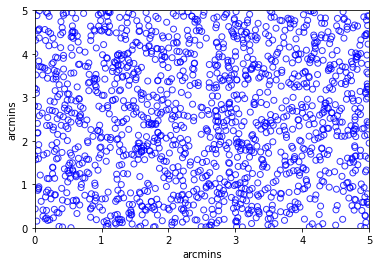

In [5]:
# This is the background locations
P = h_PoissonPP( bk_rate, Dx ).T
plt.scatter( P[0], P[1], edgecolor='b', facecolor='none', alpha=0.8 )
plt.xlim(0,Dx) ; plt.ylim(0,Dx)
plt.xlabel('arcmins')
plt.ylabel('arcmins')

In [6]:
Px_deg = (P[0]-(Dx/2))/60. + ra # Background souces ra
Py_deg = (P[1]-(Dx/2))/60. + dec # Background sources dec
rx = P[0] - (Dx/2)
ry = P[1] - (Dx/2)
bk_r = np.sqrt(rx**2 + ry**2)

Text(0, 0.5, 'DEC')

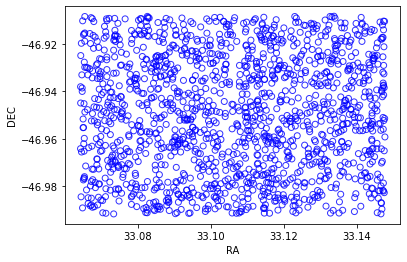

In [7]:
plt.scatter( Px_deg, Py_deg, edgecolor='b', facecolor='none', alpha=0.8 )
plt.xlabel('RA')
plt.ylabel('DEC')

In [8]:
# Read in the SDWFS AGN catalog
sdwfs_iragn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SDWFS_cutout_IRAGN.fits')

In [9]:
number_to_draw=Px_deg.shape[0]
print('number to draw:', number_to_draw)
length_of_sdwfs=len(sdwfs_iragn)
print('length of sdwfs to draw from:', length_of_sdwfs)

number to draw: 1481
length of sdwfs to draw from: 11710


In [10]:
sdwfs_iragn_pd = sdwfs_iragn.to_pandas()
sdwfs_iragn_pd = sdwfs_iragn_pd.sample(n=number_to_draw, weights=f'SELECTION_MEMBERSHIP_{color_cut_at_z:.2f}', replace=True, random_state=rng)
bk_ra=Px_deg
bk_dec=Py_deg
bk_ch1=np.array(sdwfs_iragn_pd['I1_MAG_APER4'])
bk_ch2=np.array(sdwfs_iragn_pd['I2_MAG_APER4'])
bk_z=np.array(sdwfs_iragn_pd['REDSHIFT'])

bk_z.shape

(1481,)

In [11]:
# making a pandas dataframe of the background for this cluster
bk_d = {'ra': bk_ra, 'dec': bk_dec, 'CH1': bk_ch1, 'CH2': bk_ch2, 'z': bk_z, 'r':bk_r}
bk_df=pd.DataFrame(data=bk_d)

In [12]:
bk_df

,ra,dec,CH1,CH2,z,r
0,33.074612,-46.943052,17.45,16.84,1.53,1.928861
1,33.097564,-46.930256,17.85,17.31,1.06,1.288256
2,33.117819,-46.977223,18.02,17.09,1.48,1.780703
3,33.099499,-46.943949,17.94,17.14,1.78,0.532853
4,33.130152,-46.916578,16.51,15.84,1.19,2.474103
...,...,...,...,...,...,...
1476,33.070023,-46.926530,18.02,17.09,1.48,2.577332
1477,33.139189,-46.944463,17.07,16.43,1.75,2.018871
1478,33.095625,-46.948146,16.93,16.00,2.58,0.632364
1479,33.074375,-46.916821,17.90,17.27,1.48,2.750184


### Cluster sources

Text(0, 0.5, 'rate per sq arcmin')

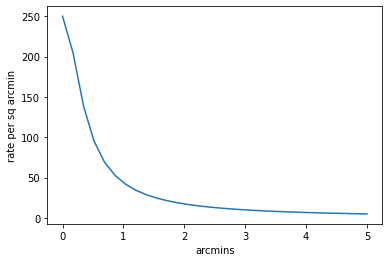

In [13]:
# define a simple model to start with
# let y be some rate function n(r)
r_array=np.linspace(0,5,30)

A0=cl_rate; beta0=0.8; rc0=0.3; rmax0=5.0; back0=0.0 # background is 0.0 as only cluster here

def model_rate(r: ArrayLike, A: float, beta: float, rc: float, rmax: float, back: float) -> np.ndarray:
    n=A * ((1+(r/rc)**2)**(-1.5*beta+0.5)) + back
    n[r>rmax]=0.0
    return n

plt.plot(r_array,model_rate(r_array,A0,beta0,rc0,rmax0,back0))
plt.xlabel('arcmins')
plt.ylabel('rate per sq arcmin')

Text(0, 0.5, 'arcmins')

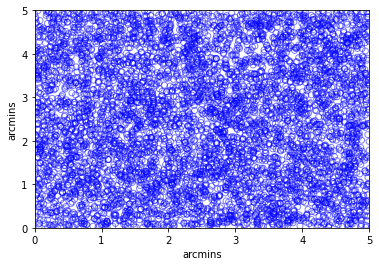

In [14]:
# simualte h_pp for max rate
max_rate=np.max(model_rate(r_array,A0,beta0,rc0,rmax0,back0))
P = h_PoissonPP( max_rate, Dx ).T
plt.scatter( P[0], P[1], edgecolor='b', facecolor='none', alpha=0.5 )
plt.xlim(0,Dx) ; plt.ylim(0,Dx)
plt.xlabel('arcmins')
plt.ylabel('arcmins')

maximum rate is 250.0
662


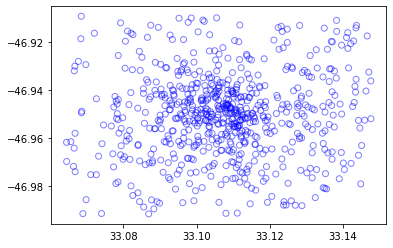

In [15]:
# now thin this all out
rad=np.sqrt((P[0]-Dx/2.)**2. + (P[1]-Dx/2.)**2.)
rate_at_rad=model_rate(rad,A0,beta0,rc0,rmax0,back0)
print("maximum rate is", max_rate)
prob_accept_reject=rate_at_rad/max_rate

D=np.random.uniform(0,1,len(rate_at_rad))
truth = D <= prob_accept_reject

print(len(truth[truth==True]))
n_true=np.where(truth == True)

Px_deg_cl = (P[0][n_true]-(Dx/2))/60.  + ra # Background souces ra
Py_deg_cl = (P[1][n_true]-(Dx/2))/60.  + dec # Background sources dec
rx = P[0][n_true] - (Dx/2)
ry = P[1][n_true] - (Dx/2)
cl_r = np.sqrt(rx**2 + ry**2)

x1=Px_deg_cl; y1=Py_deg_cl
plt.scatter(x1, y1, edgecolor='b', facecolor='none', alpha=0.5)

In [16]:
### CHANGE ME - this should be just the AGN that we draw from

# cluster no
number_to_draw_cl=Px_deg_cl.shape[0]
print('number to draw:', number_to_draw_cl)

# sdwfs df with z cut
red_hi=redshift+redshift_uncert
red_lo=redshift-redshift_uncert
sdwfs_cat_final_z = sdwfs_iragn[(sdwfs_iragn['REDSHIFT']>red_lo) & (sdwfs_iragn['REDSHIFT']<red_hi)]

# length_of_sdwfs_cl=sdwfs_cat_final_z['CH1_APMAG4'].shape[0] #### CHANGE ME TO CORRECT DF!!!!
# print('length of sdwfs to draw from:', length_of_sdwfs_cl)


number to draw: 662


In [17]:
sdwfs_iragn_cl_pd = sdwfs_cat_final_z.to_pandas()
sdwfs_iragn_cl_pd = sdwfs_iragn_cl_pd.sample(n=number_to_draw_cl, weights=f'SELECTION_MEMBERSHIP_{color_cut_at_z:.2f}', replace=True, random_state=rng)
cl_ra=Px_deg_cl
cl_dec=Py_deg_cl
cl_ch1=np.array(sdwfs_iragn_cl_pd['I1_MAG_APER4'])
cl_ch2=np.array(sdwfs_iragn_cl_pd['I2_MAG_APER4'])
cl_z=np.array(sdwfs_iragn_cl_pd['REDSHIFT'])
cl_z.shape

(662,)

In [18]:
# making a pandas dataframe of the background for this cluster
cl_d = {'ra': cl_ra, 'dec': cl_dec, 'CH1': cl_ch1, 'CH2': cl_ch2, 'z': cl_z, 'r': cl_r}
cl_df=pd.DataFrame(data=cl_d)

In [19]:
cl_df

,ra,dec,CH1,CH2,z,r
0,33.129452,-46.931803,15.44,14.62,0.60,1.781048
1,33.092580,-46.948231,15.44,14.62,0.60,0.812151
2,33.082594,-46.983800,15.65,14.96,0.59,2.466788
3,33.107260,-46.953708,15.44,14.62,0.60,0.234987
4,33.078798,-46.957902,15.44,14.62,0.60,1.699604
...,...,...,...,...,...,...
657,33.111376,-46.971050,15.65,14.96,0.59,1.303524
658,33.087209,-46.955833,17.91,17.30,0.58,1.180530
659,33.087909,-46.970234,17.91,17.30,0.58,1.628530
660,33.113139,-46.962172,15.44,14.62,0.60,0.846659


### All toegther

In [20]:
all_df=pd.concat([cl_df,bk_df])
all_df



,ra,dec,CH1,CH2,z,r
0,33.129452,-46.931803,15.44,14.62,0.60,1.781048
1,33.092580,-46.948231,15.44,14.62,0.60,0.812151
2,33.082594,-46.983800,15.65,14.96,0.59,2.466788
3,33.107260,-46.953708,15.44,14.62,0.60,0.234987
4,33.078798,-46.957902,15.44,14.62,0.60,1.699604
...,...,...,...,...,...,...
1476,33.070023,-46.926530,18.02,17.09,1.48,2.577332
1477,33.139189,-46.944463,17.07,16.43,1.75,2.018871
1478,33.095625,-46.948146,16.93,16.00,2.58,0.632364
1479,33.074375,-46.916821,17.90,17.27,1.48,2.750184


## Now try monte-carlo

In [21]:
def lnlike(points: ArrayLike, integral: float) -> float:
    pi_loglike_sum=np.log(points)
    pi_loglike=np.sum(pi_loglike_sum) - integral
    return pi_loglike

In [23]:
def lnpriorU(theta: ArrayLike):
    beta, A, back = theta
    if 0.1 <= beta <=1.0 and 0.0 <= A < 500 and 58.0 <= back <= 62.0:
        return 0.0
    return -np.inf

In [24]:
def lnpriorN(pos_val: float, mean: float, sig: float) -> float:
    return -0.5*np.sum(((pos_val-mean)/sig)**2)

In [25]:
def lnprob(pos: tuple[float], points: ArrayLike) -> float:
    A=pos[0]
    beta=beta0
    rc=rc0
    rmax=5.0
    backbk=pos[1]
    backcl=0.0
    
    theta = np.vstack((beta,A,backbk))
    lpU=lnpriorU(theta)
    if not np.isfinite(lpU):
        return -np.inf
    
    #### CHANGE ME DON"T THINK THESE ARE RIGHT SHAPES
    
    ri=points
    # nicl=model_rate(ri, A, beta, rc, rmax, 0.0)
    # nibk=model_rate(ri, 0.0, beta, rc, rmax, backbk)
    # ni=nicl+nibk
    ni = model_rate(ri, A, beta, rc, rmax, backbk)
    
    rall=np.linspace(0.0,rmax,100)
    # nallcl=model_rate(rall,A,beta,rc,rmax,0.0)
    # nallbk=model_rate(rall,0.0,beta,rc,rmax,backbk)
    # nall=nallcl+nallbk
    nall = model_rate(rall, A, beta, rc, rmax, backbk)
    
    integral=np.trapz(2.*np.pi*nall*rall,rall)
        
    lpP=lnlike(ni * ri, integral)
    return lpP + lpU

In [26]:
import emcee
from scipy import integrate

In [27]:
all_df

,ra,dec,CH1,CH2,z,r
0,33.129452,-46.931803,15.44,14.62,0.60,1.781048
1,33.092580,-46.948231,15.44,14.62,0.60,0.812151
2,33.082594,-46.983800,15.65,14.96,0.59,2.466788
3,33.107260,-46.953708,15.44,14.62,0.60,0.234987
4,33.078798,-46.957902,15.44,14.62,0.60,1.699604
...,...,...,...,...,...,...
1476,33.070023,-46.926530,18.02,17.09,1.48,2.577332
1477,33.139189,-46.944463,17.07,16.43,1.75,2.018871
1478,33.095625,-46.948146,16.93,16.00,2.58,0.632364
1479,33.074375,-46.916821,17.90,17.27,1.48,2.750184


In [28]:
rad_final=np.array(bk_df['r'])
points=rad_final

start=np.array([cl_rate, bk_rate])
sigma=np.array([0.0005,0.0001])
ndim, nwalkers = 2, 50
### generate the starting positions
# pos = np.array([start + rng.uniform(loc=0, scale=sigma, size=ndim) for i in range(nwalkers)])
pos = np.array([rng.uniform(low=0., high=500, size=nwalkers),
                rng.uniform(low=58.0, high=62.0, size=nwalkers)]).T

###
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=1, args=[points])
sampler.run_mcmc(pos, 5000, progress=True)
###


print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

100%|██████████| 5000/5000 [00:26<00:00, 187.56it/s]

Mean acceptance fraction: 0.605


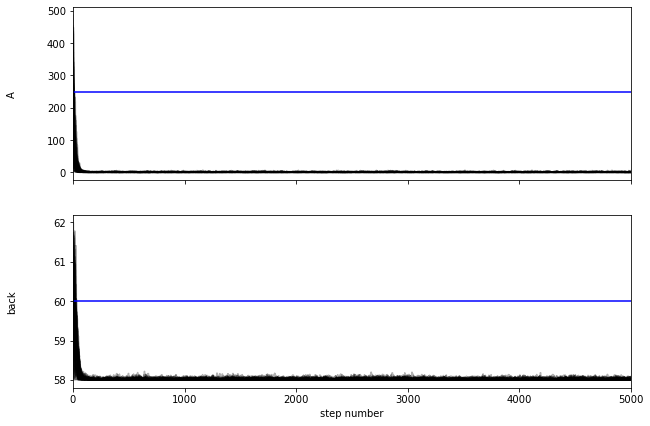

In [29]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex='col')
samples = sampler.get_chain()
labels = ["A", "back"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].axhline(y=cl_rate, c='b')
axes[1].axhline(y=bk_rate, c='b')
axes[-1].set_xlabel("step number");

In [30]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(16300, 2)


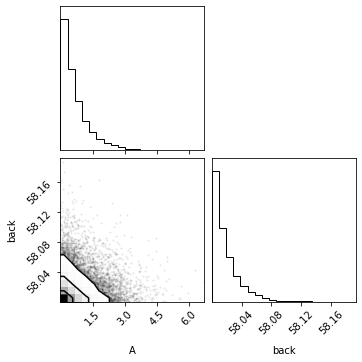

In [31]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[250, 600]
);

In [ ]:
cl_rate, bk_rate